In [16]:
import os
import math
from PIL import Image

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch
from HemaDataset import HemaDataset
from HemaModel import HemaModel
from DINOv2ForRadiology.dinov2.eval.segmentation.utils import UNetDecoder
from DINOv2ForRadiology.dinov2.data.transforms import make_segmentation_train_transforms, make_segmentation_eval_transforms

from monai.losses.dice import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
def show_tensor_image(tensor):
    """
    Displays a PyTorch tensor as an image.

    Parameters:
    - tensor: a PyTorch tensor of shape (C, H, W) for an image.

    """
    # Check if tensor needs to be normalized
    if tensor.dtype == torch.float32:
        if tensor.max() <= 1.0:
            tensor = tensor
        else:
            # Assuming the max value represents white
            tensor = tensor / 255.0
    # Convert tensor to numpy
    np_image = tensor.numpy()
    
    # Convert from C x H x W to H x W x C for matplotlib
    if np_image.shape[0] == 1: # grayscale
        np_image = np_image.squeeze()  # remove channel dim
        plt.imshow(np_image, cmap='gray')
    else:
        np_image = np.transpose(np_image, (1, 2, 0))
        plt.imshow(np_image)
    
    plt.axis('off')  # No axes for a cleaner image
    plt.show()


def one_epoch(model, data_loader, loss_fn=None, optimizer=None, scheduler=None, eval_metric=None):
    
    is_training = model.training
    all_loss = []

    for image, mask in data_loader:

        image = image.cuda(non_blocking=True)
        mask = mask.cuda(non_blocking=True)

        output = model(image)

        if is_training:
            loss = loss_fn(output, mask)

            # compute the gradients
            optimizer.zero_grad()
            loss.backward()

            # step
            optimizer.step()
            scheduler.step()

            all_loss.append(loss.item())
        else:
            eval_metric(y_pred=output, y=mask)
                
    if is_training:
        return ( sum(all_loss) / len(all_loss) ) # return average loss
    return eval_metric # else, return evaluation metric

def train(model, train_loader, val_loader, loss_fn, optimizer, scheduler=None, epochs=100):
    
    best_dice = 0
    for epoch in range(epochs):
        
        model.train()
        avrg_loss = one_epoch(model=model, data_loader=train_loader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)    
        
        if epoch % 10 == 0 or epoch == (epochs-1):
        
            model.eval()
            print(f"epoch: {epoch}, loss {avrg_loss}, ", end="")
            eval_metric = DiceMetric(include_background=False, reduction="none") # bug with reduction "mean," will do it manually.

            eval_metric = one_epoch(model=model, data_loader=val_loader, eval_metric=eval_metric)

            dice = eval_metric.aggregate().mean(axis=1).mean(axis=0).item() # take average across classes first (channels), then across batch. 
            print(f"dice: {dice}") 

            if dice > best_dice:
                best_dice = dice
                best_model = model.state_dict()

    return best_model, best_dice

In [4]:
image_size = 448
root = f"{os.getcwd() + os.sep}data{os.sep}Dataset011_Cell"

train_image_transform, train_target_transform  = make_segmentation_train_transforms(resize_size=image_size)
eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms(resize_size=image_size)

train_dataset = HemaDataset(root=root, split="train", seg_entire_cell=True, image_transform=train_image_transform, target_transform=train_target_transform)
val_dataset = HemaDataset(root=root, split="val", seg_entire_cell=True, image_transform=eval_image_transform, target_transform=eval_target_transform)

In [5]:
batch_size = 8
epochs = 100
epoch_length = math.ceil(len(train_dataset) / batch_size)
max_iter = epoch_length * epochs 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

loss_fn = DiceLoss(sigmoid=True)

In [ ]:
lrs = [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7]
results = {}

for lr in lrs:
    
    encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').cuda()
    decoder = UNetDecoder(in_channels=encoder.embed_dim, out_channels=3, image_size=448, resize_image=True).cuda()
    model = HemaModel(encoder=encoder, decoder=decoder)
 
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)    
        
    optim_param_groups = [
        {"params": encoder.parameters(), "lr": lr},
        {"params": decoder.parameters(), "lr": 1e-2}
    ]
    
    optimizer = torch.optim.AdamW(optim_param_groups, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter, eta_min=0)

    _, dice = train(model=model, train_loader=train_loader, val_loader=val_loader, loss_fn=loss_fn, optimizer=optimizer,
                scheduler=scheduler, epochs=epochs)
    
    results[lr] = dice
    print(f"best result for lr {lr} is {dice}")

In [24]:
# import json

# with open('dinov2_val.json', 'w') as f:
#     # Use json.dump to write the dictionary to the file
#     json.dump(results, f)

In [8]:
epochs = 1000

encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').cuda()
decoder = UNetDecoder(in_channels=encoder.embed_dim, out_channels=3, image_size=448, resize_image=True).cuda()
model = HemaModel(encoder=encoder, decoder=decoder)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)    

optim_param_groups = [
    {"params": encoder.parameters(), "lr": 1e-5},
    {"params": decoder.parameters(), "lr": 1e-2}
]

optimizer = torch.optim.AdamW(optim_param_groups, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter, eta_min=0)

best_model, dice = train(model=model, train_loader=train_loader, val_loader=val_loader, loss_fn=loss_fn, optimizer=optimizer,
            scheduler=scheduler, epochs=epochs)

Using cache found in /home/baharoon/.cache/torch/hub/facebookresearch_dinov2_main


Using layers [ 1  3  6  8 11] to get UNet skip connections.
Using 2 GPUs!
epoch: 0, loss 0.5438459937771162, dice: 0.48086756467819214
epoch: 10, loss 0.47253525132934254, dice: 0.28014451265335083
epoch: 20, loss 0.45688839505116147, dice: 0.8930609226226807
epoch: 30, loss 0.44655093799034756, dice: 0.9019090533256531
epoch: 40, loss 0.4493237075706323, dice: 0.908482551574707
epoch: 50, loss 0.4559318944811821, dice: 0.9130682945251465
epoch: 60, loss 0.450972984234492, dice: 0.9212315678596497
epoch: 70, loss 0.4469568294783433, dice: 0.9262842535972595
epoch: 80, loss 0.4475233865280946, dice: 0.9305381774902344
epoch: 90, loss 0.45198361327250797, dice: 0.9312506914138794
epoch: 100, loss 0.4476187663773696, dice: 0.9316806793212891
epoch: 110, loss 0.45104623461763066, dice: 0.9309989213943481
epoch: 120, loss 0.44836990783611935, dice: 0.9315680265426636
epoch: 130, loss 0.4476891818145911, dice: 0.9003208875656128
epoch: 140, loss 0.45029227435588837, dice: 0.9403809309005737


In [12]:
torch.save(best_model, "../dinov2-unet.pth")

In [6]:
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').cuda()
decoder = UNetDecoder(in_channels=encoder.embed_dim, out_channels=3, image_size=448, resize_image=True).cuda()
model = HemaModel(encoder=encoder, decoder=decoder)

state_dict = torch.load("../dinov2-unet.pth")
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)

Using cache found in /home/baharoon/.cache/torch/hub/facebookresearch_dinov2_main
/home/baharoon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/baharoon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/baharoon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Using layers [ 1  3  6  8 11] to get UNet skip connections.


<All keys matched successfully>

In [19]:
output_path = "./bonus"
external_output_path = output_path + os.sep + "seg-External-Bonus"
internal_output_path = output_path + os.sep + "seg-Internal-Bonus"
os.makedirs(external_output_path, exist_ok=True)
os.makedirs(internal_output_path, exist_ok=True)

internal_dataset = HemaDataset(root=root, split="test-in", seg_entire_cell=True,
                               image_transform=eval_image_transform, return_meta=True)

external_dataset = HemaDataset(root=root, split="test-ex", seg_entire_cell=True,
                               image_transform=eval_image_transform, return_meta=True)

In [ ]:
print("predicting internal dataset.")
for i, _, meta in internal_dataset:
    i = i.cuda()
    
    size = meta['size']
    path = meta['path']
    
    pred = model(i.unsqueeze(0)).squeeze(0)
    pred = torch.sigmoid(pred)
    output = torch.zeros(448, 448, dtype=torch.float32)
    for i in range(pred.shape[0]):
        output[pred[i] > 0.5] = i
    output = torch.nn.functional.interpolate(output.unsqueeze(0).unsqueeze(0), size=(size, size), mode='nearest-exact')
    output = output.cpu().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    output = Image.fromarray(output)
    
    image_name = path.split("/")[-1]
    output.save(internal_output_path + os.sep + image_name)
    
print("predicting external dataset.")
for i, _, meta in external_dataset:
    i = i.cuda()
    
    size = meta['size']
    path = meta['path']
    
    pred = model(i.unsqueeze(0)).squeeze(0)
    pred = torch.sigmoid(pred)
    output = torch.zeros(448, 448, dtype=torch.float32)
    for i in range(pred.shape[0]):
        output[pred[i] > 0.5] = i
    output = torch.nn.functional.interpolate(output.unsqueeze(0).unsqueeze(0), size=(size, size), mode='nearest-exact')
    output = output.cpu().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    output = Image.fromarray(output)
    
    image_name = path.split("/")[-1]
    output.save(external_output_path + os.sep + image_name)

predicting external dataset.


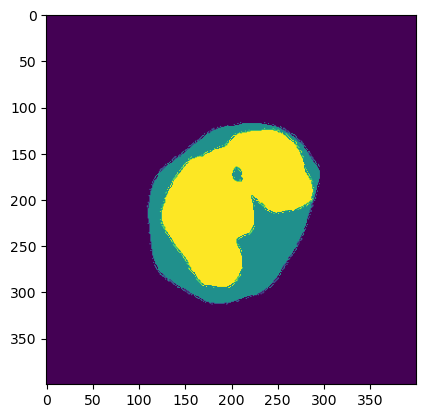

In [33]:
plt.imshow(output)
plt.show()